# Exploring Dandiset 000690: Allen Institute Openscope - Vision2Hippocampus project

> **Note**: This notebook was AI-generated and has not been fully verified. Users should be cautious when interpreting the code or results and verify important analyses independently.

## Overview of the Dandiset

This notebook explores data from the Allen Institute Openscope - Vision2Hippocampus project (Dandiset 000690). This dataset contains extracellular electrophysiology recordings from multiple brain regions, including the thalamus, neocortex, and hippocampus in mice. It focuses on understanding how visual information is processed and transformed as it travels through the brain, from the visual pathways to the hippocampus.

The project explores how neural representations of simple visual stimuli (like bars of light) and natural stimuli (such as movies of eagles and squirrels) evolve as they travel from the thalamus through various visual cortical areas and into the hippocampus.

For more information, visit: [https://dandiarchive.org/dandiset/000690](https://dandiarchive.org/dandiset/000690)

## Required Packages

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import remfile
import pynwb
from scipy import signal
import seaborn as sns
from matplotlib.cm import get_cmap

# Configure visualizations
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_theme()  # Using seaborn styling for plots

## Loading the Dandiset

First, we'll connect to the DANDI archive and load basic information about the dataset:

In [2]:
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("000690")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")

Dandiset name: Allen Institute Openscope - Vision2Hippocampus project
Dandiset URL: https://dandiarchive.org/dandiset/000690/0.250326.0015


Let's get a list of the assets in the Dandiset to understand what data is available:

In [3]:
# List the assets in the Dandiset
assets = list(dandiset.get_assets())
print(f"\nFound {len(assets)} assets in the dataset")

# Display a few example files to understand the structure
print("\nExample asset paths:")
for asset in assets[:5]:
    print(f"- {asset.path} (Size: {asset.size/1e9:.2f} GB)")


Found 156 assets in the dataset

Example asset paths:
- sub-692077/sub-692077_ses-1300222049_probe-4_ecephys.nwb (Size: 1.68 GB)
- sub-692077/sub-692077_ses-1300222049_probe-3_ecephys.nwb (Size: 1.78 GB)
- sub-692077/sub-692077_ses-1300222049_probe-2_ecephys.nwb (Size: 1.65 GB)
- sub-692077/sub-692077_ses-1300222049_probe-0_ecephys.nwb (Size: 1.75 GB)
- sub-692077/sub-692077_ses-1300222049.nwb (Size: 2.45 GB)


The dataset contains multiple subjects (mice), each with different recording sessions. Each session typically has a main NWB file containing metadata and references to more specific data files, including:

- Probe-specific electrophysiology files (containing LFP and spike data)
- Image files (containing visual stimulus information)

We'll explore different aspects of this data, focusing on neural activity and its relationship to visual stimuli.

## Exploring Local Field Potential (LFP) Data

Let's explore the LFP data from one of the probes. LFP reflects the summed electrical activity of many neurons and provides insights into population-level neural dynamics.

In [4]:
# Define a function to load an NWB file from a URL
def load_nwb_from_url(url):
    print(f"Loading NWB file from {url}")
    remote_file = remfile.File(url)
    h5_file = h5py.File(remote_file)
    io = pynwb.NWBHDF5IO(file=h5_file)
    return io.read()

Let's load an LFP data file from the first subject:

In [5]:
# URL for an LFP data file (change if needed)
lfp_url = "https://api.dandiarchive.org/api/assets/ba8760f9-91fe-4c1c-97e6-590bed6a783b/download/"
lfp_nwb = load_nwb_from_url(lfp_url)

# Print basic info
print(f"Session ID: {lfp_nwb.session_id}")
print(f"Session description: {lfp_nwb.session_description}")
print(f"Subject ID: {lfp_nwb.subject.subject_id}")
print(f"Subject species: {lfp_nwb.subject.species}")

Loading NWB file from https://api.dandiarchive.org/api/assets/ba8760f9-91fe-4c1c-97e6-590bed6a783b/download/


/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Session ID: 1298465622
Session description: LFP data and associated info for one probe
Subject ID: 692072
Subject species: Mus musculus


Each recording probe captures data from electrodes placed in different brain regions. Let's see what brain regions are represented in this recording:

Total number of electrodes: 95
Brain regions represented: ['PF' 'TH' 'LP' 'DG-mo' 'DG-sg' 'DG-po' 'CA1' 'VISa6b' 'VISa6a' 'RSPagl6a'
 'RSPagl5' 'RSPagl2/3' 'RSPagl1' 'root']

Electrodes per brain region:
location
CA1          23
LP           16
DG-mo        12
RSPagl5       9
root          8
DG-sg         6
RSPagl2/3     5
RSPagl6a      4
TH            3
RSPagl1       3
VISa6a        2
DG-po         2
PF            1
VISa6b        1
Name: count, dtype: int64


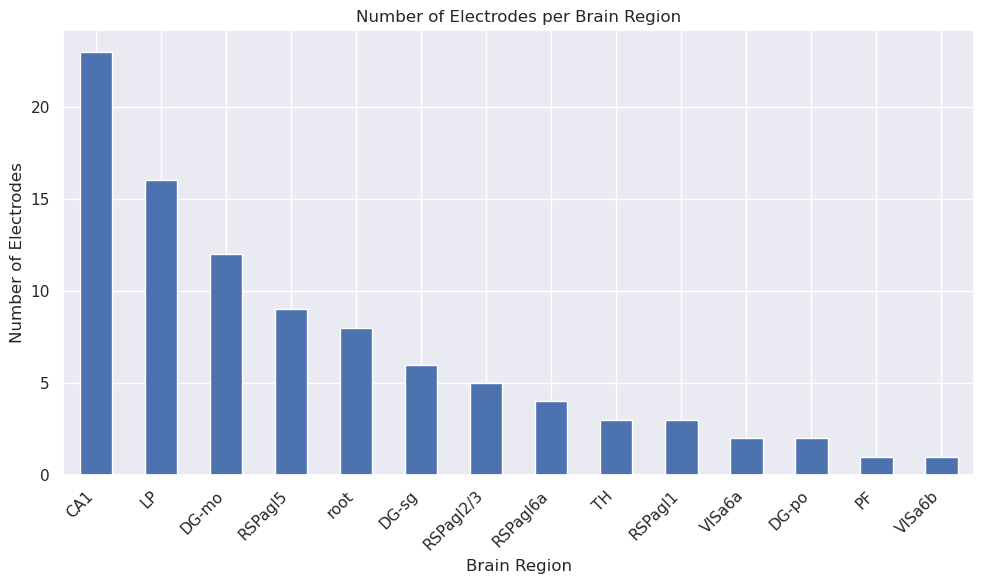

In [6]:
# Get electrode information
electrode_df = lfp_nwb.electrodes.to_dataframe()
print(f"Total number of electrodes: {len(electrode_df)}")
print(f"Brain regions represented: {electrode_df['location'].unique()}")

# Count electrodes per brain region
region_counts = electrode_df['location'].value_counts()
print("\nElectrodes per brain region:")
print(region_counts)

# Plot brain region distribution
plt.figure(figsize=(10, 6))
region_counts.plot(kind='bar')
plt.title('Number of Electrodes per Brain Region')
plt.xlabel('Brain Region')
plt.ylabel('Number of Electrodes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Now, let's examine the LFP data itself. We'll plot LFP traces from different brain regions:

In [7]:
# Get LFP data 
lfp_data = lfp_nwb.acquisition['probe_0_lfp_data']
print(f"LFP data shape: {lfp_data.data.shape}")  # [timestamps, channels]
print(f"LFP units: {lfp_data.unit}")
print(f"LFP sampling rate: {lfp_nwb.electrode_groups['probeA'].lfp_sampling_rate} Hz")

# Sample parameters for visualization
sample_rate = lfp_nwb.electrode_groups['probeA'].lfp_sampling_rate  # Hz
duration_sec = 2  # seconds to display
n_samples = int(duration_sec * sample_rate)

# Select a random starting point (not too close to the end)
max_start_idx = lfp_data.data.shape[0] - n_samples
start_idx = np.random.randint(0, max_start_idx)

# Subsample data to save memory and speed up processing
times = lfp_data.timestamps[start_idx:start_idx+n_samples]
time_sec = times - times[0]  # Make zero-based

LFP data shape: (10117092, 95)
LFP units: volts
LFP sampling rate: 625.0 Hz


Let's plot LFP traces from different brain regions to see how activity varies across regions:

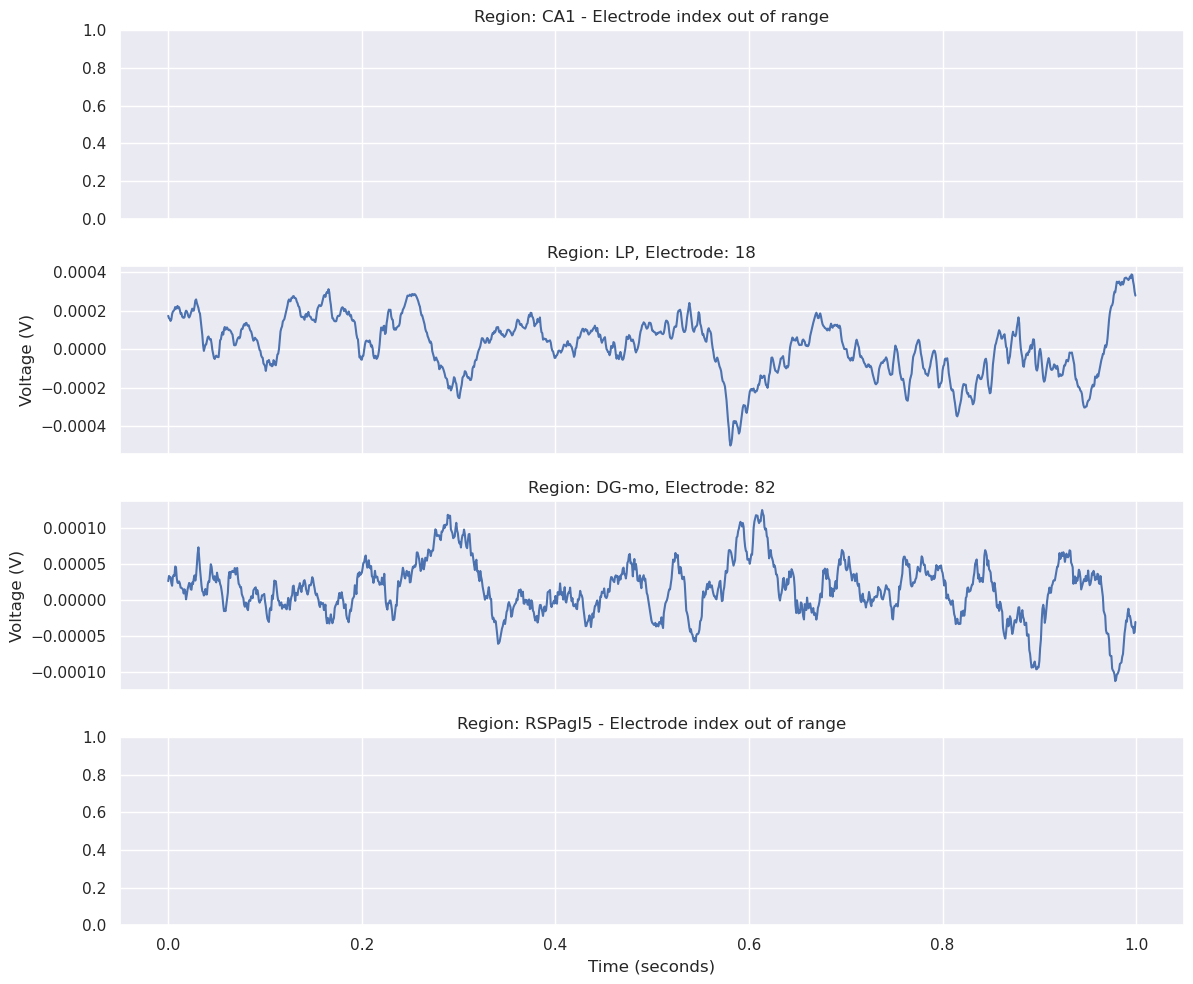

In [8]:
# Select one electrode from each of the top 4 brain regions with the most electrodes
top_regions = region_counts.nlargest(4).index.tolist()

fig, axs = plt.subplots(len(top_regions), 1, figsize=(12, 10), sharex=True)

for i, region in enumerate(top_regions):
    # Find the first electrode from this region
    region_electrodes = electrode_df[electrode_df['location'] == region].index.tolist()
    if len(region_electrodes) > 0:
        electrode_idx = region_electrodes[0]
        # Make sure electrode idx is within range
        if electrode_idx < lfp_data.data.shape[1]:
            # Extract and plot LFP data
            lfp_trace = lfp_data.data[start_idx:start_idx+n_samples, electrode_idx]
            axs[i].plot(time_sec, lfp_trace)
            axs[i].set_ylabel('Voltage (V)')
            axs[i].set_title(f'Region: {region}, Electrode: {electrode_idx}')
        else:
            axs[i].set_title(f'Region: {region} - Electrode index out of range')
    else:
        axs[i].set_title(f'No electrodes found for region: {region}')

axs[-1].set_xlabel('Time (seconds)')
plt.tight_layout()
plt.show()

Let's also visualize the LFP activity across multiple channels using a heatmap:

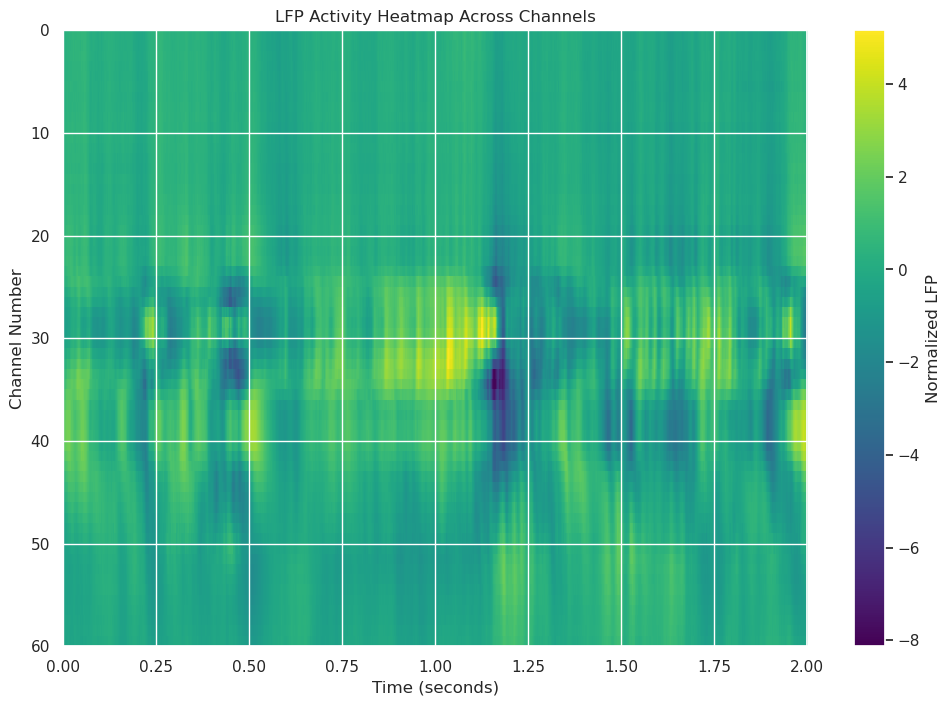

In [9]:
# Create a heatmap of LFP activity
n_channels_to_plot = min(60, lfp_data.data.shape[1])  # Limit for visibility
plt.figure(figsize=(12, 8))

# Get a short time window
short_time = 2  # 2 seconds
short_samples = int(short_time * sample_rate)
lfp_short = lfp_data.data[start_idx:start_idx+short_samples, :n_channels_to_plot]

# Normalize for better visualization
lfp_norm = (lfp_short - np.mean(lfp_short)) / np.std(lfp_short)

# Create the heatmap
plt.imshow(lfp_norm.T, aspect='auto', interpolation='none',
           extent=[0, short_time, n_channels_to_plot, 0],
           cmap='viridis')
plt.colorbar(label='Normalized LFP')
plt.xlabel('Time (seconds)')
plt.ylabel('Channel Number')
plt.title('LFP Activity Heatmap Across Channels')
plt.show()

Let's analyze the frequency content of LFP signals from different brain regions:

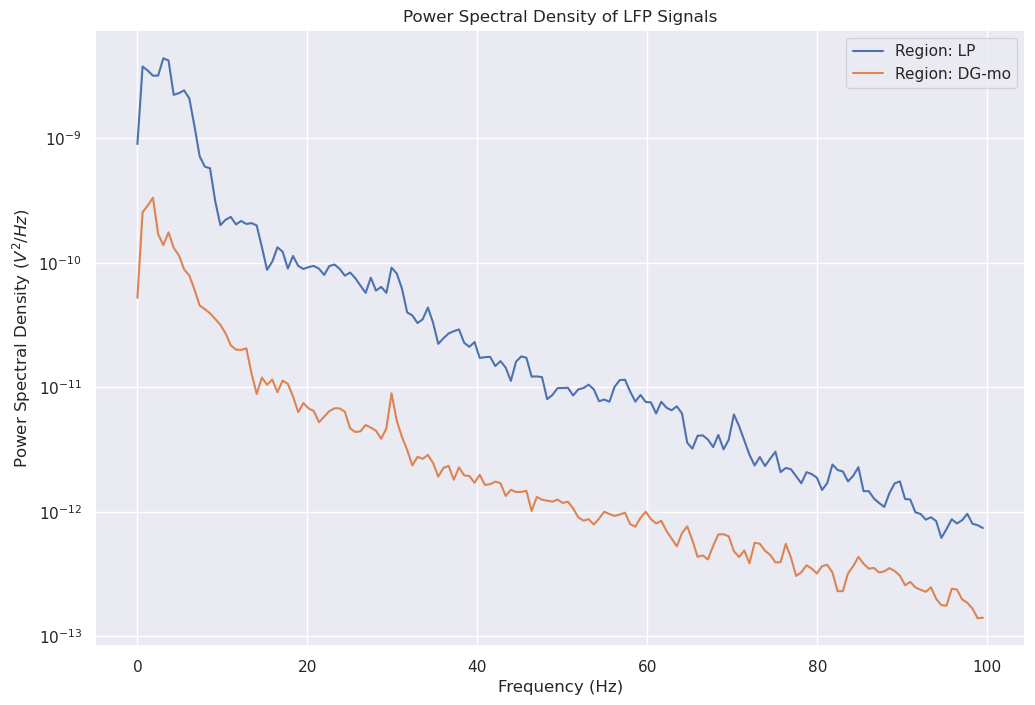

In [10]:
# Calculate and plot power spectral density for selected brain regions
plt.figure(figsize=(12, 8))

# Use the same top regions as before
for region in top_regions:
    region_electrodes = electrode_df[electrode_df['location'] == region].index.tolist()
    
    if len(region_electrodes) > 0:
        electrode_idx = region_electrodes[0]
        if electrode_idx < lfp_data.data.shape[1]:
            # Get a longer segment for frequency analysis
            freq_duration_sec = 30  # 30 seconds will give better frequency resolution
            n_freq_samples = int(freq_duration_sec * sample_rate)
            
            # Make sure we don't exceed data bounds
            freq_start_idx = min(start_idx, max_start_idx - n_freq_samples)
            lfp_segment = lfp_data.data[freq_start_idx:freq_start_idx+n_freq_samples, electrode_idx]
            
            # Calculate PSD using Welch's method
            f, Pxx = signal.welch(lfp_segment, fs=sample_rate, nperseg=1024)
            
            # Plot only frequencies up to 100 Hz (typical for LFP analysis)
            mask = f <= 100
            plt.semilogy(f[mask], Pxx[mask], label=f'Region: {region}')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density ($V^2/Hz$)')
plt.title('Power Spectral Density of LFP Signals')
plt.legend()
plt.grid(True)
plt.show()

The power spectrum shows several frequency bands typical in LFP recordings:
- Delta (0-4 Hz): Associated with slow wave activity, often prominent during sleep and quiet wakefulness
- Theta (4-8 Hz): Important for memory processes in the hippocampus
- Alpha (8-12 Hz): Associated with relaxed wakefulness and inhibitory mechanisms
- Beta (12-30 Hz): Associated with active concentration and motor control
- Gamma (30-100 Hz): Associated with attention, perception, and information binding

## Exploring Spike (Unit) Data

Now let's examine the spike data, which represents the action potentials of individual neurons. This will help us understand how single neurons respond to visual stimuli.

In [11]:
# Load a NWB file that contains spike data
spike_url = "https://api.dandiarchive.org/api/assets/fbcd4fe5-7107-41b2-b154-b67f783f23dc/download/"
spike_nwb = load_nwb_from_url(spike_url)

Loading NWB file from https://api.dandiarchive.org/api/assets/fbcd4fe5-7107-41b2-b154-b67f783f23dc/download/


/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Let's explore the units (neurons) that were recorded:

In [12]:
# Get unit information
if hasattr(spike_nwb, 'units') and spike_nwb.units is not None:
    units_df = spike_nwb.units.to_dataframe()
    print(f"Total number of units: {len(units_df)}")
    
    # What properties do the units have?
    print("\nUnit properties:")
    for column in units_df.columns:
        print(f"- {column}")
    
    # Print some firing rate statistics if available
    if 'firing_rate' in units_df.columns:
        print(f"\nFiring rate stats:")
        print(f"Mean: {units_df['firing_rate'].mean():.2f} Hz")
        print(f"Median: {units_df['firing_rate'].median():.2f} Hz")
        print(f"Min: {units_df['firing_rate'].min():.2f} Hz")
        print(f"Max: {units_df['firing_rate'].max():.2f} Hz")
else:
    print("No units data found in this file")    

Total number of units: 2764

Unit properties:
- recovery_slope
- l_ratio
- d_prime
- max_drift
- firing_rate
- isi_violations
- presence_ratio
- spread
- velocity_above
- repolarization_slope
- cluster_id
- isolation_distance
- nn_miss_rate
- waveform_duration
- waveform_halfwidth
- peak_channel_id
- quality
- velocity_below
- amplitude
- PT_ratio
- snr
- nn_hit_rate
- cumulative_drift
- amplitude_cutoff
- silhouette_score
- local_index
- spike_times
- spike_amplitudes
- waveform_mean

Firing rate stats:
Mean: 3.67 Hz
Median: 1.91 Hz
Min: 0.00 Hz
Max: 137.74 Hz


Let's visualize the distribution of firing rates:

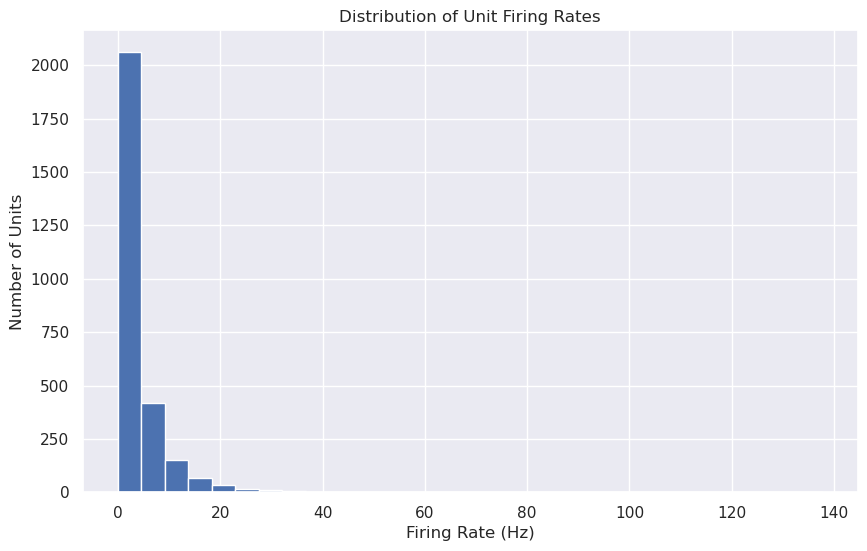

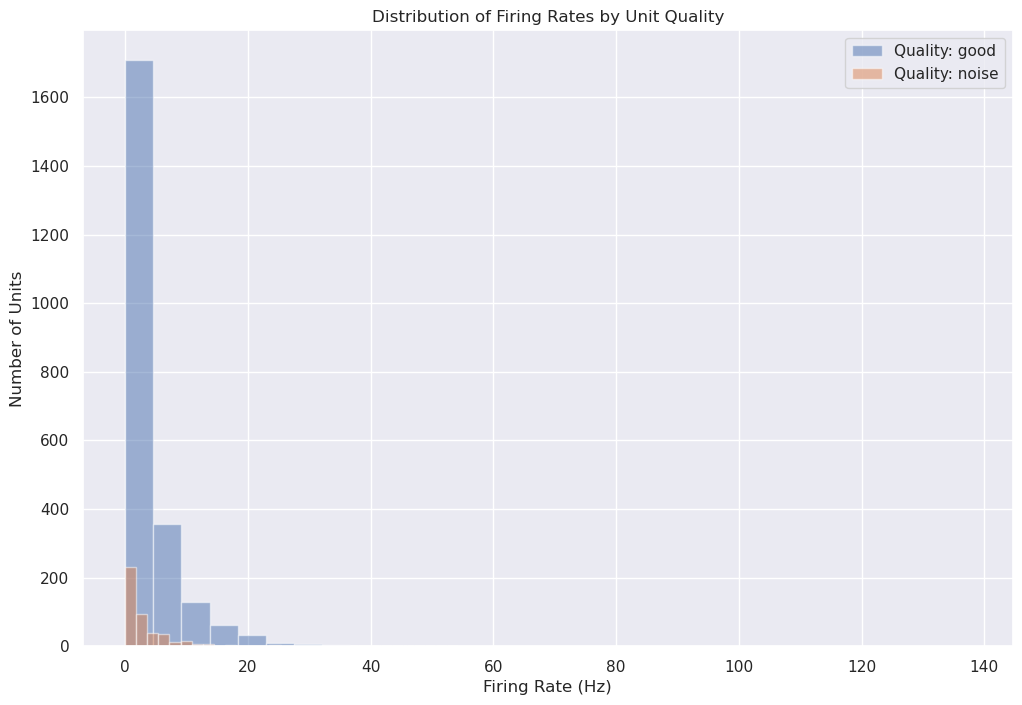

In [13]:
# Plot histogram of firing rates if available
if hasattr(spike_nwb, 'units') and 'firing_rate' in units_df.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(units_df['firing_rate'], bins=30)
    plt.xlabel('Firing Rate (Hz)')
    plt.ylabel('Number of Units')
    plt.title('Distribution of Unit Firing Rates')
    plt.show()
    
    # Check if quality field is available for further analysis
    if 'quality' in units_df.columns:
        # Plot firing rates by quality
        plt.figure(figsize=(12, 8))
        quality_values = units_df['quality'].unique()
        for quality in quality_values:
            subset = units_df[units_df['quality'] == quality]
            plt.hist(subset['firing_rate'], bins=30, alpha=0.5, label=f'Quality: {quality}')
        
        plt.xlabel('Firing Rate (Hz)')
        plt.ylabel('Number of Units')
        plt.title('Distribution of Firing Rates by Unit Quality')
        plt.legend()
        plt.show()

Let's examine the spiking patterns of a few units by looking at their inter-spike intervals (ISIs):


Unit 1594: 1114849 spikes
  - Mean ISI: 0.007260 seconds
  - Median ISI: 0.003400 seconds
  - Min ISI: 0.000033 seconds


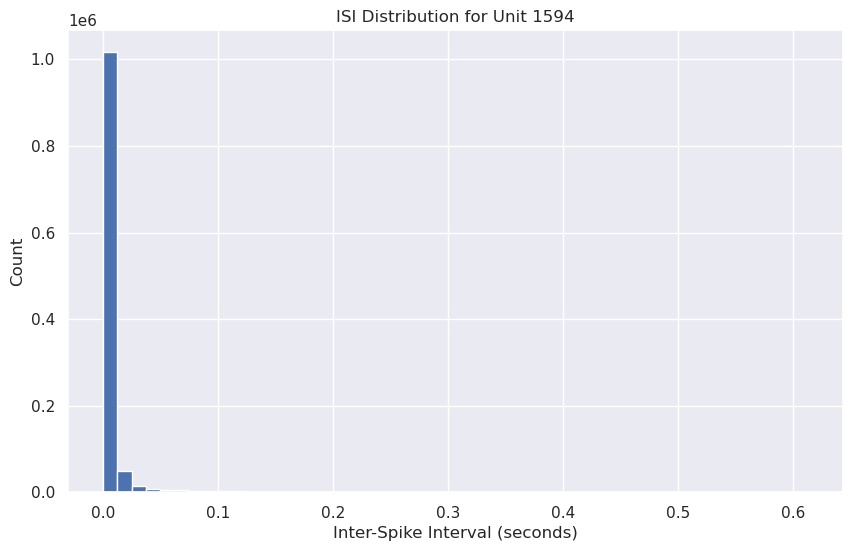


Unit 1586: 552665 spikes
  - Mean ISI: 0.014645 seconds
  - Median ISI: 0.007900 seconds
  - Min ISI: 0.000033 seconds


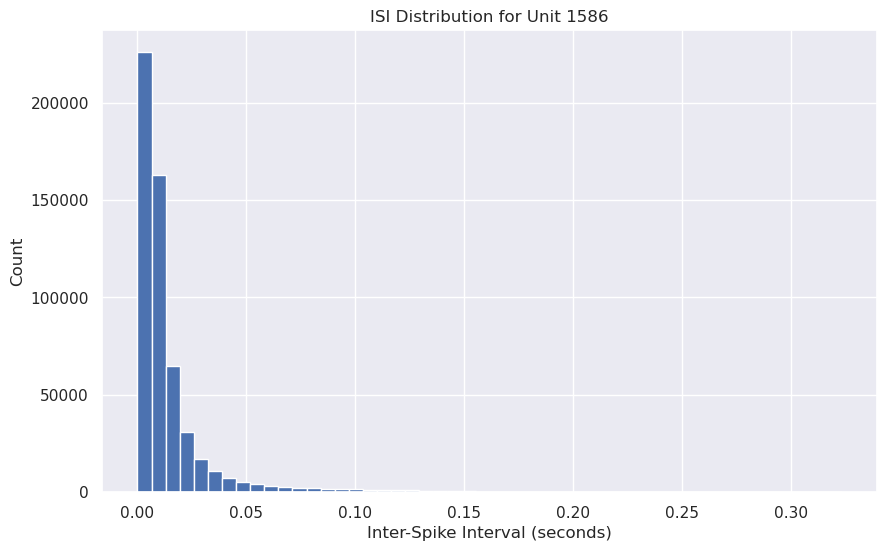


Unit 1230: 471645 spikes
  - Mean ISI: 0.017160 seconds
  - Median ISI: 0.008167 seconds
  - Min ISI: 0.000033 seconds


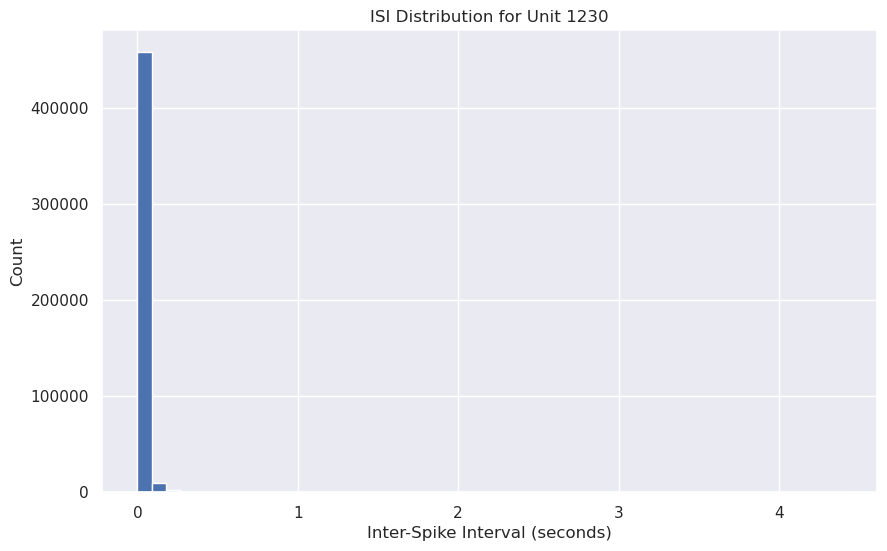

In [14]:
# Analyze spike timing patterns for a few units
if hasattr(spike_nwb, 'units') and spike_nwb.units is not None:
    # Get units with the most spikes for more reliable analysis
    unit_spike_counts = []
    for i in range(len(units_df)):
        try:
            spike_times = spike_nwb.units['spike_times'][i]
            unit_spike_counts.append((i, len(spike_times)))
        except Exception as e:
            pass
    
    # Sort by spike count (descending)
    unit_spike_counts.sort(key=lambda x: x[1], reverse=True)
    
    # Analyze top 3 units by spike count
    for i, (unit_id, spike_count) in enumerate(unit_spike_counts[:3]):
        if i >= 3:  # Limit to 3 units
            break
            
        spike_times = spike_nwb.units['spike_times'][unit_id]
        print(f"\nUnit {unit_id}: {spike_count} spikes")
        
        # Calculate ISI
        if spike_count >= 2:
            isis = np.diff(spike_times)
            print(f"  - Mean ISI: {np.mean(isis):.6f} seconds")
            print(f"  - Median ISI: {np.median(isis):.6f} seconds")
            print(f"  - Min ISI: {np.min(isis):.6f} seconds")
            
            # Plot ISI histogram
            plt.figure(figsize=(10, 6))
            plt.hist(isis, bins=50)
            plt.xlabel('Inter-Spike Interval (seconds)')
            plt.ylabel('Count')
            plt.title(f'ISI Distribution for Unit {unit_id}')
            plt.show()

## Visual Stimuli and Neural Responses

One of the key aspects of this dataset is the relationship between visual stimuli and neural activity. Let's explore the visual stimuli information:

Stimulus intervals (presentations):


- Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations: 28800 presentations


- Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations: 14400 presentations


- GreenSAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations: 14400 presentations


- Ring_Wd15_Vel2_Bndry1_Cntst0_loop_presentations: 28800 presentations


- SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations: 28800 presentations


- SAC_Wd15_Vel2_Bndry1_Cntst1_loop_presentations: 14400 presentations


- SAC_Wd15_Vel2_Bndry2_Cntst0_loop_presentations: 17040 presentations


- SAC_Wd15_Vel2_Bndry2_Cntst0_oneway_presentations: 8520 presentations


- SAC_Wd15_Vel2_Bndry3_Cntst0_loop_presentations: 22320 presentations


- SAC_Wd15_Vel8_Bndry1_Cntst0_loop_presentations: 57600 presentations



Analyzing example stimulus: Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
Number of presentations: 28800
Mean duration: 0.016681 seconds
Duration range: 0.016679 - 0.016682 seconds


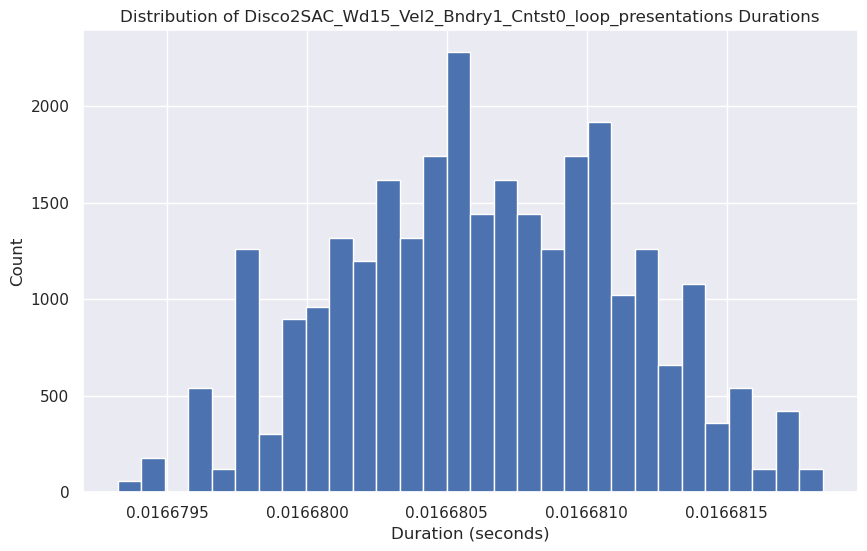

In [15]:
# Check for stimulus information
if hasattr(spike_nwb, 'intervals') and len(spike_nwb.intervals) > 0:
    print("Stimulus intervals (presentations):")
    for interval_name in list(spike_nwb.intervals)[:10]:  # Show first 10 for brevity
        try:
            interval_df = spike_nwb.intervals[interval_name].to_dataframe()
            print(f"- {interval_name}: {len(interval_df)} presentations")
        except Exception as e:
            print(f"  Error reading interval {interval_name}: {e}")

    # Choose one stimulus type to analyze in more detail
    example_stimulus = list(spike_nwb.intervals)[0]
    try:
        stim_df = spike_nwb.intervals[example_stimulus].to_dataframe()
        print(f"\nAnalyzing example stimulus: {example_stimulus}")
        print(f"Number of presentations: {len(stim_df)}")
        
        # Calculate presentation durations
        durations = stim_df['stop_time'] - stim_df['start_time']
        print(f"Mean duration: {durations.mean():.6f} seconds")
        print(f"Duration range: {durations.min():.6f} - {durations.max():.6f} seconds")
        
        # Plot duration histogram
        plt.figure(figsize=(10, 6))
        plt.hist(durations, bins=30)
        plt.xlabel('Duration (seconds)')
        plt.ylabel('Count')
        plt.title(f'Distribution of {example_stimulus} Durations')
        plt.show()
        
    except Exception as e:
        print(f"Error analyzing stimulus: {e}")
else:
    print("No stimulus intervals found in this file")

Let's try to create a simple PSTH (Peri-Stimulus Time Histogram) to see how neurons respond to visual stimuli:

Creating PSTH for unit 1594 and stimulus Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations


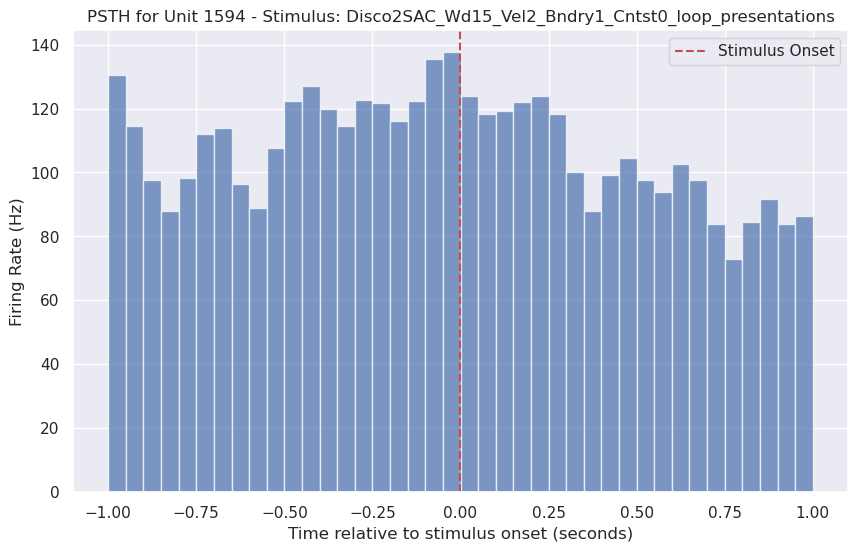

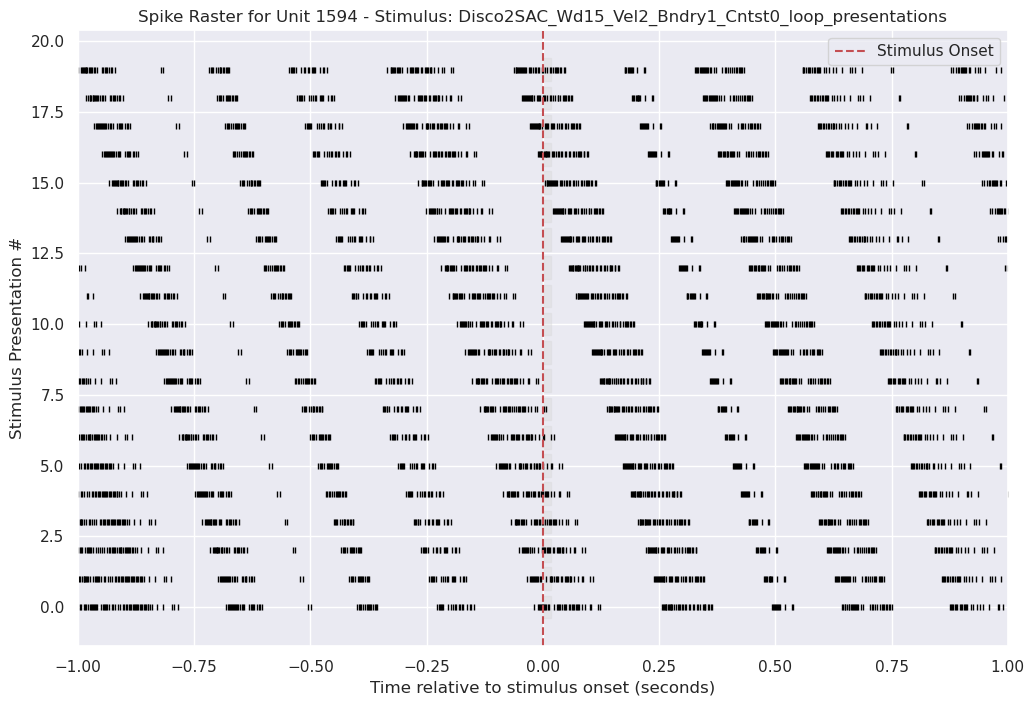

In [16]:
def create_psth(unit_id, stimulus_name, nwb, bin_size=0.05, window_size=1.0):
    """
    Create a Peri-Stimulus Time Histogram for a given unit and stimulus
    
    Parameters:
    -----------
    unit_id : int
        ID of the unit to analyze
    stimulus_name : str
        Name of the stimulus interval to use
    nwb : NWBFile
        The NWB file object
    bin_size : float
        Size of time bins in seconds
    window_size : float
        Size of the window around stimulus onset in seconds
        
    Returns:
    --------
    None - creates a plot
    """
    try:
        # Get spike times for this unit
        spike_times = nwb.units['spike_times'][unit_id]
        
        # Get stimulus presentations
        stim_df = nwb.intervals[stimulus_name].to_dataframe()
        
        # Limit to first 50 presentations for speed
        max_stim = min(50, len(stim_df))
        stim_df = stim_df.iloc[:max_stim]
        
        # Parameters for PSTH
        bins = np.arange(-window_size, window_size + bin_size, bin_size)
        bin_centers = bins[:-1] + bin_size/2
        all_counts = np.zeros((len(stim_df), len(bins)-1))
        
        # Compute PSTH
        for i, (_, stim) in enumerate(stim_df.iterrows()):
            stim_start = stim['start_time']
            
            # Find spikes relative to stimulus onset
            relative_spike_times = spike_times - stim_start
            
            # Filter spikes within our window
            mask = (relative_spike_times >= -window_size) & (relative_spike_times <= window_size)
            windowed_spikes = relative_spike_times[mask]
            
            # Count spikes in bins
            counts, _ = np.histogram(windowed_spikes, bins)
            all_counts[i, :] = counts
        
        # Average across all stimulus presentations
        mean_counts = all_counts.mean(axis=0) / bin_size  # Convert to Hz
        
        # Plot PSTH
        plt.figure(figsize=(10, 6))
        plt.bar(bin_centers, mean_counts, width=bin_size, alpha=0.7)
        plt.axvline(x=0, color='r', linestyle='--', label='Stimulus Onset')
        plt.xlabel('Time relative to stimulus onset (seconds)')
        plt.ylabel('Firing Rate (Hz)')
        plt.title(f'PSTH for Unit {unit_id} - Stimulus: {stimulus_name}')
        plt.legend()
        plt.show()
        
        # Also create a raster plot
        plt.figure(figsize=(12, 8))
        for i, (_, stim) in enumerate(stim_df.iloc[:20].iterrows()):  # First 20 presentations
            stim_start = stim['start_time']
            stim_end = stim['stop_time']
            
            # Find spikes relative to stimulus onset
            relative_spike_times = spike_times - stim_start
            
            # Get spikes within window
            mask = (relative_spike_times >= -window_size) & (relative_spike_times <= window_size)
            windowed_spikes = relative_spike_times[mask]
            
            # Plot raster
            plt.plot(windowed_spikes, np.ones_like(windowed_spikes) * i, '|', markersize=5, color='black')
            # Highlight stimulus duration
            plt.axhspan(i-0.4, i+0.4, xmin=(0+window_size)/(2*window_size), 
                       xmax=((stim_end-stim_start)+window_size)/(2*window_size), 
                       color='lightgray', alpha=0.3)
        
        plt.axvline(x=0, color='r', linestyle='--', label='Stimulus Onset')
        plt.xlabel('Time relative to stimulus onset (seconds)')
        plt.ylabel('Stimulus Presentation #')
        plt.xlim([-window_size, window_size])
        plt.title(f'Spike Raster for Unit {unit_id} - Stimulus: {stimulus_name}')
        plt.legend()
        plt.show()
        
    except Exception as e:
        print(f"Error creating PSTH: {e}")

# Try to create a PSTH for a unit with many spikes
if hasattr(spike_nwb, 'units') and hasattr(spike_nwb, 'intervals'):
    # Find a unit with lots of spikes
    if 'unit_spike_counts' not in locals():
        unit_spike_counts = []
        for i in range(len(units_df)):
            try:
                spike_times = spike_nwb.units['spike_times'][i]
                unit_spike_counts.append((i, len(spike_times)))
            except Exception:
                pass
        unit_spike_counts.sort(key=lambda x: x[1], reverse=True)
    
    if unit_spike_counts and len(spike_nwb.intervals) > 0:
        # Use the unit with the most spikes
        unit_id = unit_spike_counts[0][0]
        # Use the first available stimulus type
        stimulus_name = list(spike_nwb.intervals)[0]
        
        print(f"Creating PSTH for unit {unit_id} and stimulus {stimulus_name}")
        create_psth(unit_id, stimulus_name, spike_nwb)

## Conclusion

In this notebook, we've explored Dandiset 000690 (Allen Institute Openscope - Vision2Hippocampus project), which contains extracellular electrophysiology recordings from mice being shown various visual stimuli. We've examined:

1. **LFP activity**: We observed local field potentials from different brain regions, which reflect the summed activity of many neurons.

2. **Spike data**: We analyzed individual neuron activity through spike timing and firing rate distributions.

3. **Visual stimuli**: We examined the structure of visual stimulus presentations and their durations.

4. **Neural responses**: We visualized how neurons respond to visual stimuli through peri-stimulus time histograms and raster plots.

This dataset is valuable for understanding how visual information is processed and transformed as it travels from the visual system to higher brain areas like the hippocampus. There are many more analyses that could be performed with this rich dataset, including:

- Comparing responses across different brain regions
- Examining differences between simple (bar) stimuli and complex (natural movie) stimuli
- Analyzing population dynamics and correlations between neurons
- Looking at changes in neural activity during different behavioral states (e.g., running vs. stationary)

Further analysis could help elucidate how the brain creates abstract representations from specific sensory inputs.

## References

- Dandiset 000690: https://dandiarchive.org/dandiset/000690
- Allen Institute Openscope: https://alleninstitute.org/what-we-do/brain-science/research/mindscope-program/openscope/
- PyNWB documentation: https://pynwb.readthedocs.io/